In [1]:
#### load packages, *.h5 folder and exp.h5 file location
%matplotlib widget

from essential_func import *
from analysis_data import *

qgrid2 = np.hstack([np.arange(0.005, 0.0499, 0.001), np.arange(0.05, 0.099, 0.002), np.arange(0.1, 3.2, 0.005)])

samples_csv                = 'data_directory.csv'
default_sample_dir         = '20-Dec'               # 'July-2021-Sample#6'    '21-Nov'   'July-sorted'   '20-Dec'    '22-Oct'   'Oct-2022-1971'   'Mar-2023-Sample#1948'
csv_and_code_abs_directory = '/Users/bashit.a/Documents/Alzheimer/Codes/'

dropdown_name, dropdown_name_list, cwd, exp_folder = change_python_path(dropdown_name = default_sample_dir, csv_file_location = csv_and_code_abs_directory, samples_csv = samples_csv)

Python directory is set to load samples from : 20-Dec


In [7]:
## Do cluster labeling
import cv2
from scipy.ndimage import label

img_gray = np.asarray(img_orig, dtype=np.uint8)
_, thresh_img = cv2.threshold(img_gray, 0, 255,cv2.THRESH_BINARY); #plt.imshow(thresh_img, cmap='gray')
labeled_array, num_features = label(thresh_img, np.ones((3,3)))
print('Total clusters = ', num_features)

Width, Height = labeled_array.shape[1], labeled_array.shape[0]
sna = snaking(Width, Height , np.arange(0, Width*Height))

[print('label = ', i, sna[labeled_array==i]) for i in np.unique(labeled_array) if i!=0]

NameError: name 'img_orig' is not defined

In [21]:
from generate_files import *
save_mat('IqBS', ('IqBS', 'qgrid2'), (IqBS, qgrid2))

In [8]:
### Correlation coefficients analysis

Width, Height = 61, 81
sna = snaking(Width, Height , np.arange(0, Width*Height))
print(sna)

grid = np.zeros((Height,Width),dtype=object)
for i in range(0,Height):
    for j in range(0,Width):
        grid[i,j]=(i,j)
grid = grid[::-1]
print(grid)

[[4880 4881 4882 ... 4938 4939 4940]
 [4879 4878 4877 ... 4821 4820 4819]
 [4758 4759 4760 ... 4816 4817 4818]
 ...
 [ 122  123  124 ...  180  181  182]
 [ 121  120  119 ...   63   62   61]
 [   0    1    2 ...   58   59   60]]
[[(80, 0) (80, 1) (80, 2) ... (80, 58) (80, 59) (80, 60)]
 [(79, 0) (79, 1) (79, 2) ... (79, 58) (79, 59) (79, 60)]
 [(78, 0) (78, 1) (78, 2) ... (78, 58) (78, 59) (78, 60)]
 ...
 [(2, 0) (2, 1) (2, 2) ... (2, 58) (2, 59) (2, 60)]
 [(1, 0) (1, 1) (1, 2) ... (1, 58) (1, 59) (1, 60)]
 [(0, 0) (0, 1) (0, 2) ... (0, 58) (0, 59) (0, 60)]]


In [15]:
frame = 4940
def frame_to_idx(frame):
    idx = [i for i in grid[sna==frame]]
    return idx

def idx_to_frame(l):
    idx = []
    for i in l:
        a, b = i
        x = [i==(a,b) for i in grid[Height-a-1]]
        idx.append(sna[Height-a-1, np.where(x)].tolist())
        print(idx)
    return flatten(idx)

l = frame_to_idx(frame)
print(frame_to_idx(frame))
print(idx_to_frame(l))

[(80, 60)]
[[[4940]]]
[4940]


In [32]:
### locating valid neighbor indices 3*3 kernel
a, b = 80, 60
l = []
for i in range(a-1,a+2):
    for j in range(b-1,b+2):
        if (i,j) !=(a,b) and i>=0 and j>=0 and i<Height and j <Width:
            l.append((i,j))
print(l)

[(79, 59), (79, 60), (80, 59)]


In [33]:
## look for frames gotten from previous indices
idx = []
for i in l:
    a, b = i
    x = [i==(a,b) for i in grid[Height-a-1]]
    idx.append(sna[Height-a-1, np.where(x)].tolist())
flatten(idx)

[4820, 4819, 4939]

In [26]:
from scipy.io import loadmat
annots = loadmat('2048_B8_Iq.mat')

interactive(children=(Dropdown(description='File : ', options=('1892_EC-roi0_masked.h5', '1892_FC-roi0_masked.…

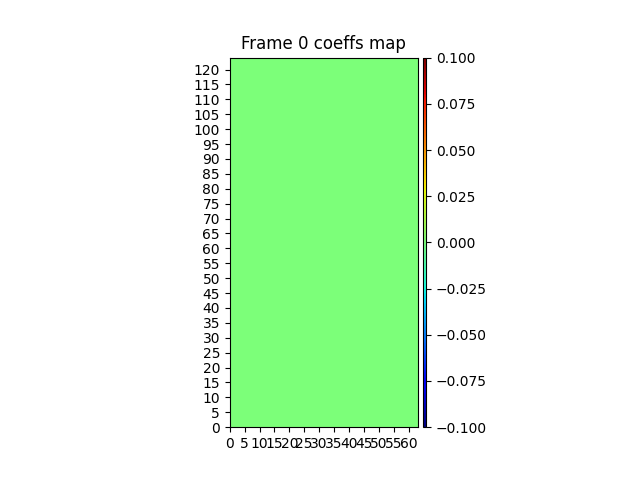

In [12]:
### Correlation coefficient calculation on individual frame
%matplotlib widget
from functools import reduce

def coeffs_map(file, ref_frame, thr_coeff, search_q, normalize, L):
    b = np.ones((1,L))/L    # numerator co-effs of filter transfer function
    a = np.ones(1)          # denominator co-effs of filter transfer function

    q_min, q_max = search_q
    Width, Height = width_height(file)
    Iq = read_Iq(file, 'merged')

    Iq = signal.fftconvolve(Iq,b,mode='same',) if L>1 else Iq         # filter output using convolution
    Iq = Iq/np.max(Iq,axis=1).reshape(-1,1) if normalize else Iq      # test how normalizing affecing data points print(Iq[0][:10])

    q_min_idx, q_max_idx = qgrid_to_indices(qgrid2, q_min), qgrid_to_indices(qgrid2, q_max)
    sna = snaking(Width, Height)
    global cluster
    cluster = []; coeffs = []
    for frame in range(Width * Height):
        coeff = np.corrcoef(Iq[ref_frame][q_min_idx:q_max_idx], Iq[frame][q_min_idx:q_max_idx])[0,1]
        if coeff >= thr_coeff:
            cluster.append(frame)
            coeffs.append(coeff)
    A = np.array([np.zeros((Height,Width)),sna])   # zero values matrix (A[0]=0) with frame numbers depth (A[1]=frames)

    A = from_clusterFr_ceffs_to_matrix(A, cluster, coeffs)
    
    f,ax = plt.subplots()
    plot_heat_map_from_data(A[0], Width, Height, args = (f,ax), title= f'Frame {ref_frame} coeffs map', cmap='jet')  # inferno

#coeffs_map(file, ref_frame, thr_coeff,  search_q = (q_min, q_max))

files = cwd_files_search_with('.h5')
dropdown = ipywidgets.Dropdown(options= files, value = files[0], description='File : ', disabled=False)
frame = ipywidgets.IntSlider(value=0,                   min=0,           max= 15000, step=1, description='Frame : ', continuous_update=False, layout=ipywidgets.Layout(width='50%')) # reduce(lambda x,y: x*y-1 , width_height(dropdown.value) )
thr_coeff = ipywidgets.FloatSlider(value = 0.96 ,       min= 0,       max=1,    step=0.001 , description='THR Coeff:', continuous_update=False, layout=ipywidgets.Layout(width='50%'), readout=True, readout_format='.3f')    
search_q = ipywidgets.FloatRangeSlider( value=(1, 2), min=qgrid2[0],   max=qgrid2[-1], step=0.05,   description='q Range:',  disabled=False,  continuous_update=False,  orientation='horizontal',  readout=True, readout_format='.3f',layout=ipywidgets.Layout(width='50%') )
normalize = ipywidgets.Checkbox(value=True, description='Normalize', disabled=False, indent=False )
n_point = ipywidgets.IntSlider(value=4,                   min=1,         max=10, step=1, description='N-point : ', continuous_update=False, layout=ipywidgets.Layout(width='30%'))


ipywidgets.interactive(coeffs_map, file=dropdown, ref_frame=frame, thr_coeff=thr_coeff, search_q= search_q, normalize= normalize, L = n_point)

In [56]:
### checking convolution funcitons
L = 5
b = np.ones((1,L))/L
x = np.array([1,2,3,5,2,7]).reshape(1,-1)
print(signal.convolve(x,b, mode='same'))

L=5                        # L-point filter
b = (np.ones((1,L)))/L     # numerator co-effs of filter transfer function
a = np.ones(1)             # denominator co-effs of filter transfer function
y = signal.fftconvolve(x,b,mode='same',)   # filter output using convolution
print(y)
qgrid2[375]

[[1.2 2.2 2.6 3.8 3.4 2.8]]
[[1.2 2.2 2.6 3.8 3.4 2.8]]


1.6250000000000013

In [176]:
import functools
import ipywidgets as widgets
from IPython.display import display
button = widgets.Button(description="Click Me!")
display(button)

def fun(a):
    print(a)

def on_button_clicked(b, rs_="some_default_string"):
    fun(rs_)

button.on_click(functools.partial(on_button_clicked, rs_="abcdefg"))

In [4]:
### difference (original - filter) intensity heatmap
out = ipywidgets.Output()

@out.capture(clear_output=True)
def on_button_clicked(_):   
    %matplotlib widget

    Width, Height = width_height(file=dropdown.value)
    
    ### Data preprocessing - after filtering (4 point filtering)
    q_min, q_max = search_q.value
    X = file_preprocess(file = dropdown.value, window_size=n_point.value, qgrid=qgrid2, normalize=False, directory = os.getcwd())
    print(X.shape,peak_q.value)
    diff_patterns = find_rep_value(qgrid2, X , args=peak_q.value, method = 'point')
    filtered_diff_patterns = snaking(Width, Height, diff_patterns)
    filtered_diff_patterns = filtered_diff_patterns.reshape(Height,Width)

    ### original data -- no filtering
    Iq = read_Iq(file = dropdown.value, scattering = 'merged')
    q_min_idx, q_max_idx = qgrid_to_indices(qgrid2, q_min), qgrid_to_indices(qgrid2, q_max)
    diff_patterns = find_rep_value(qgrid2, Iq , args=peak_q.value, method = 'point')
    img_orig = snaking(Width, Height, diff_patterns)
    img_orig = img_orig.reshape(Height,Width)

    subtracted = (img_orig-filtered_diff_patterns).reshape(Height,Width)

    fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(16,3))
    
    plot_heat_map_from_data(img_orig, Width, Height, args = (fig, ax1), title= 'original', cmap="jet")
    plot_heat_map_from_data(filtered_diff_patterns, Width, Height, args = (fig, ax2), title= 'filtered', cmap="jet")
    plot_heat_map_from_data(subtracted, Width, Height, args = (fig, ax3), title= 'subtracted', cmap="viridis")
    
    
### file selection and operation widgets  
files      = cwd_files_search_with('.h5')
dropdown   = ipywidgets.Dropdown(options= files, value = files[0], description='File : ', disabled=False)
search_q   = ipywidgets.FloatRangeSlider( value=(1, 2), min=qgrid2[0],   max=qgrid2[-1], step=0.1,   description='q Range:',  disabled=False,  continuous_update=False,  orientation='horizontal',  readout=True, readout_format='.2f',)
n_point    = ipywidgets.IntSlider(value=4,                   min=1,         max=10, step=1, description='N-point : ', continuous_update=False, layout=ipywidgets.Layout(width='30%'))
peak_q     = ipywidgets.FloatSlider(min=qgrid2[0], max=qgrid2[-1], value= 1.34, step=0.005 ,readout_format='.4f',description='q-point : ',)

#### button press event
button     = ipywidgets.Button(description='Go!');                                      button.style.button_color = "green";
button.on_click(on_button_clicked)

display(ipywidgets.HBox([dropdown, peak_q, search_q, n_point, button ]))
display(out)

Output()

In [23]:
# overlay bkg sub plots for multiple files
%matplotlib widget

X = Data_Analysis('2048_B8_masked.h5', qgrid2, window_size=4, normalize=False, normalize_at_q=normalize_at_q ,directory='/Volumes/HDD/BNL-Data/Dec-2020/')
_   = X.bkg_sub(bkg_frame = [2222])
plaque = X.IqBS[2068]

tissue = IqBSTF[0]

X = Data_Analysis('2109_EC-roi0.h5', qgrid2, window_size=4, normalize=False, normalize_at_q=normalize_at_q ,directory='/Volumes/HDD/July-2021/BNL-Data/sample-7/')
_   = X.bkg_sub(bkg_frame = [500])
tau = X.IqBS[5794]

print(plaque.shape)
plt.plot(data.qgrid[start:end], plaque[start:end],          color= 'red',        label = 'plaque'    )
plt.plot(data.qgrid[start:end], tissue[start:end],        color= 'purple',     label = 'tissue'  )
plt.plot(data.qgrid[start:end], tau[start:end],  color= 'green',               label = 'tau')
plt.legend()

NameError: name 'IqBSTF' is not defined

In [9]:
### Image registration map creation - independent cell
from matplotlib import colors

%matplotlib widget
frames = [0]      # where center of the kernal
Width, Height = (124, 61)               # image width, Height
kernal_size = 7;                             # kernal 7 - 48 frames surrounded by plaque frame
color_frames =  [7498, 7281, 7380, 7251, 7131, 6041, 5862, 6861, 5793, 5794, 5723]   # [1,2,3] or None [2367, 2420, 2421, 2491, 2492, 2548, 2549, 2615, 2616, 2676, 2677, 2738, 2739, 2740, 2804, 2805, 2806, 2862, 2863, 2864, 2931, 2932, 2933, 2934, 2987, 2988]    # manually color any frames
cmap = colors.ListedColormap(['darkblue', 'green', 'red'])

### kernal sliding and getting background frames
fr_idx = Snaking_frames_search(Width, Height)                                    # kernal frame search class
tissue_frames = np.array([])
sna = snaking(Width, Height)

for frame in frames:
    tissue_frames_temp = fr_idx.frame_idx_to_kernal_frames(kernal_size, frame)
    print(tissue_frames_temp)
    tissue_frames = np.append(tissue_frames,tissue_frames_temp)                  # kernal tissue frames

tissue_frames = tissue_frames.flatten()
A_MAT = np.array([np.zeros((Height,Width)),sna])   # zero values matrix (A[0]=0) with frame numbers depth (A[1]=frames)
A = from_clusterFr_ceffs_to_matrix(A_MAT, tissue_frames, np.full(len(tissue_frames),0.5))

B = from_clusterFr_ceffs_to_matrix(A, color_frames, np.full(len(tissue_frames),1))

fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(17,6))
plot_heat_map_from_data(B[0], Width, Height, args = (fig, ax1), title= f'original - frames-', cmap=cmap)

[0, 1, 2, 3, 247, 246, 245, 244, 248, 249, 250, 251, 495, 494, 493, 492]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [15]:
# comparing two duplicate dataframe, result is empty table
df1 = pd.read_csv('result.csv')
df2 = pd.read_csv('result-now.csv')
pd.concat([df1,df2]).drop_duplicates(keep=False)

FileNotFoundError: [Errno 2] No such file or directory: 'result-now.csv'

In [17]:
cluster = 14
cluster_frames = df['plaque-frame'][df['cluster-label']==cluster].values   # frames in each cluster
print(list(cluster_frames))

NameError: name 'df' is not defined

In [18]:
#### 1d plot for peak frames in each cluster
%matplotlib widget

peak_fr_in_cluster = df.iloc[df.index[df['selected-plaque']==True]]['plaque-frame'].values
print(peak_fr_in_cluster)
# print(peak_fr_in_cluster )
sorted_peak_fr_in_cluster = peak_fr_in_cluster[np.argsort(np.nanmax(Iq[peak_fr_in_cluster,start:end], axis=1))[::-1]]  #hightest to lowest

plt.figure()
def plot(frame):
    plt.cla()
    plt.plot(qgrid2[start:end], Iq[frame,start:end])

slider = ipywidgets.SelectionSlider(value=sorted_peak_fr_in_cluster[0], options=sorted_peak_fr_in_cluster)
ipywidgets.interact(plot, frame = slider)
print(qgrid2[start], qgrid2[end])

NameError: name 'df' is not defined

In [14]:
%matplotlib widget
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation


# https://stackoverflow.com/questions/39767612/what-is-the-equivalent-of-matlabs-imadjust-in-python
def imadjust(x,a,b,c,d,gamma=1):
    # Similar to imadjust in MATLAB.
    # Converts an image range from [a,b] to [c,d].
    # The Equation of a line can be used for this transformation:
    #   y=((d-c)/(b-a))*(x-a)+c
    # However, it is better to use a more generalized equation:
    #   y=((x-a)/(b-a))^gamma*(d-c)+c
    # If gamma is equal to 1, then the line equation is used.
    # When gamma is not equal to 1, then the transformation is not linear.

    y = (((x - a) / (b - a)) ** gamma) * (d - c) + c
    return y

In [16]:
### KMeans model
def train_KMeans(X,n_clusters):
    kmeans = KMeans(init="k-means++", n_clusters=n_clusters, n_init=4)
    kmeans.fit(X)
    labels = kmeans.predict(X)
    return labels
labels = train_KMeans(X, n_clusters=2)
df['KMeans'] = labels

### GMM model
def train_GMM(X, n_components):
    from sklearn.mixture import GaussianMixture               # import package
    gaussian_model = GaussianMixture(n_components=n_components)          # define the model
    gaussian_model.fit(X)                                     # train the model
    labels = gaussian_model.predict(X)                        # assign each data point to a cluster
    return labels

# labels = train_GMM(X, n_components=2)
# df['GMM'] = labels

### Affinity Model
def train_Affinity(X):
    af = AffinityPropagation(preference=-20000, random_state=0).fit(X)
    cluster_centers_indices = af.cluster_centers_indices_
    print('number of clusters - ', len(cluster_centers_indices))
    labels = af.labels_
    return labels

# labels = train_Affinity(X)
# df = df.assign(Affinity=labels)

print('csv file generated in ',os.getcwd())
df.to_csv('result.csv')

csv file generated in  /Users/bashit.a/Documents/Alzheimer/July-2021/BNL-Data/sample-6


In [122]:
%matplotlib widget

fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
plot_heat_map_from_data(B[0], Width, Height, args = (fig, ax1), title= f'clustered - frames-{len(df["plaque-frame"])}', cmap=cmap)

A_MAT = np.array([np.zeros((Height,Width)),sna])   # zero values matrix (A[0]=0) with frame numbers depth (A[1]=frames)
D = from_clusterFr_ceffs_to_matrix(A_MAT, cluster=df['plaque-frame'].values.astype(np.uint32), coeffs=np.uint8(imadjust(labels,labels.min(),labels.max(),0,255)))
plot_heat_map_from_data(D[0], Width, Height, args = (fig, ax2), title= f'classifier categories-{len(np.unique(labels))}', cmap=cmap)
plt.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ipython-input-122-aae9a4f2269f>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A_MAT = np.array([np.zeros((Height,Width)),sna])   # zero values matrix (A[0]=0) with frame numbers depth (A[1]=frames)


NameError: name 'imadjust' is not defined

In [329]:
### FTIR data import - MATT calculations
%matplotlib widget

mat_fname = '/Users/bashit.a/Documents/Alzheimer/FTIR/300x300Test.mat'
Width, Height = 48, 48

window_size = 4  # 4 point average
f = h5py.File(mat_fname, 'r')
wn = np.array(f['vicD']['wn'])
wn = wn[0]
# filtering
window      = np.ones(window_size)/window_size                                    # window_size = 4 --> 0.25,0.25,0.25,0.225
ftir = np.array(f['vicD']['r'])
ftir = np.transpose(np.array([np.convolve(window, ftir[:,idx], mode='same') for idx in range(ftir.shape[1])  ])) if window_size>1 else ftir   # filter output using convolution

f, axs = plt.subplots(nrows=4, ncols=3, figsize = (16,8))
frame_cor = np.arange(0,Width*Height).reshape(Width, Height)                  # indices for heat map

def ftir_heatmap(wave_number, frame, tissue, mica):

    ########## --------- matplotlib mouse hovering function for snaking --------- ##########
    numrows, numcols = Height, Width                  # format_coord function requires this global variables
    def format_coord(x, y):
        col = int(x)                                  # truncate x values
        row = int(y)                                  # truncate y values
        if 0 <= col < numcols and 0 <= row < numrows:
            z = frame_cor[row, col]        # flipping to get correct value of z     
            return 'x=%1.2f, y=%1.2f, FRAME=%d' % (x, y, z)
        else:
            return 'x=%1.2f, y=%1.2f' % (x, y)        # outside the plotting range, no need 

    axs[0,:2] = plt.subplot(4, 2, 1)
    axs[0,0].imshow(ftir[wn==wave_number,:].reshape(Width, Height), cmap='jet')
    axs[0,0].format_coord = format_coord
    axs[0,0].set(title='Heatmap FTIR')

    stds = np.zeros(len(wn))
    for wn_ in range(len(wn)):
        stds[wn_] = np.std(ftir[wn_,:])

    axs[0,2].clear()
    axs[0,2].plot(wn, stds,'blue')
    axs[0,2].scatter(wn[wn==wave_number], stds[wn==wave_number],color='red', marker = 'o')
    axs[0,2].set(xlabel = "wn", ylabel = "std")

    axs[1,0].cla()
    axs[1,0].plot(wn,ftir[:, frame], label=f'fr-{frame}')
    axs[1,0].set(xlabel = "wn", ylabel = "absorbtion")
    axs[1,0].legend()

    axs[1,1].cla()
    axs[1,1].plot(wn,ftir[:, tissue], label=f'tissue-{tissue}')
    axs[1,1].set(xlabel = "wn", ylabel = "absorbtion")
    axs[1,1].legend()

    axs[1,2].cla()
    axs[1,2].plot(wn,ftir[:, mica], label=f'mica-{mica}')
    axs[1,2].set(xlabel = "wn", ylabel = "absorbtion")
    axs[1,2].legend()

    axs[2,:] = plt.subplot(4, 1, 3)
    axs[2,0].cla()
    axs[2,0].plot(wn,ftir[:, frame] -ftir[:, mica], label=f'fr-{frame}-mica-{mica}')
    axs[2,0].plot(wn,ftir[:, tissue]-ftir[:, mica], label=f'tissue-{tissue}-mica-{mica}')
    axs[2,0].set(xlabel = "wn", ylabel = "absorbtion")
    axs[2,0].legend()

    axs[3,:] = plt.subplot(4, 1, 4)
    axs[3,0].cla()
    axs[3,0].plot(wn,(ftir[:, frame] -ftir[:, mica]) - (ftir[:, tissue]-ftir[:, mica]), label=f'fr-{frame}-tissue-{tissue}-2*mica-{mica}')
    axs[3,0].set(xlabel = "wn", ylabel = "absorbtion")
    axs[3,0].legend()

plt.tight_layout()
frame = ipywidgets.IntSlider(min=frame_cor.min(), max=frame_cor.max(), value = 670, continuous=False)   # value = int(frame_cor.mean())
tissue = ipywidgets.IntSlider(min=frame_cor.min(), max=frame_cor.max(), value = 899, continuous=False)
mica = ipywidgets.IntSlider(min=frame_cor.min(), max=frame_cor.max(), value = 521, continuous=False)

wave_number = ipywidgets.IntSlider(min=np.min(wn), max=np.max(wn), value = 1625, continuous=False)
ipywidgets.interact(ftir_heatmap, wave_number=wave_number, frame=frame, tissue=tissue, mica=mica)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(IntSlider(value=1625, description='wave_number', max=4000, min=750), IntSlider(value=670…

<function __main__.ftir_heatmap(wave_number, frame, tissue, mica)>

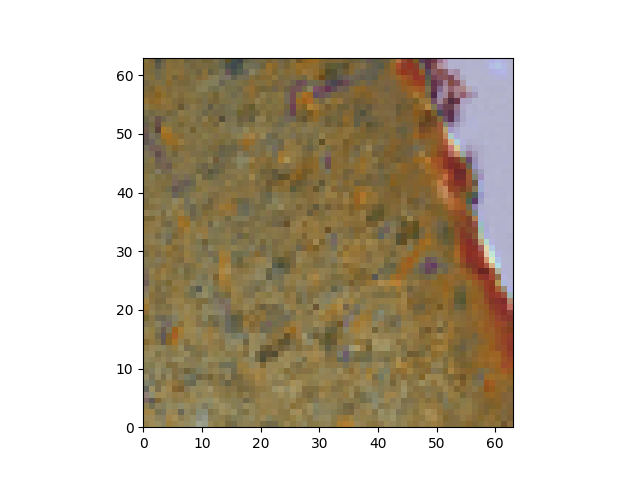

In [9]:
### Heatmap
%matplotlib widget

# dsize
Width  = 63
Height = 63

img1 = mpimg.imread('Heatmap.tif')
img1 = cv2.resize(img1, (Width, Height)) 
img2 = mpimg.imread('stained-raw.tif')
img2 = cv2.resize(img2, (Width, Height))

frame_cor = snaking(Width, Height)                  # snaking indices for heat map,
numrows, numcols = Height, Width                    # format_coord function requires this global variables
def format_coord(x, y):
    col = int(x)                                  # truncate x values
    row = int(y)                                  # truncate y values
    if 0 <= col < numcols and 0 <= row < numrows:
        z = np.flipud(frame_cor)[row, col]        # flipping to get correct value of z     
        return 'x=%1.2f, y=%1.2f, FRAME=%d' % (x, y, z)
    else:
        return 'x=%1.2f, y=%1.2f' % (x, y)        # outside the plotting range, no need

f, ax = plt.subplots()
ax.format_coord = format_coord
ax.imshow(img2,  interpolation = 'none', origin='upper', extent=[0,Width,0,Height], aspect='equal', norm=None)
ax.imshow(img_orig, cmap='jet' , interpolation = 'none', origin='upper', extent=[0,Width,0,Height], aspect='equal', norm=None, alpha=0.2)

In [2]:
%matplotlib widget

file = '2109_EC-roi0_masked.h5'  # '2048_B8_masked.h5' # '2109_EC-roi0_masked.h5' # '1892_EC-roi0_masked.h5' # '2512_EC-roi1_masked.h5' # '2029_Dentate_gyrus-roi0.h5'    # '2029_EC-roi0.h5'    '2029_Dentate_gyrus-roi0_masked.h5'  '2048_B8_masked.h5'
file_stained = '2410_EC-roi1_masked.tif'
bkg_frame                  = [1225, 1226] # [7045,7046] # 973       # background frame  '2109_EC-roi1_masked.h5'-->  [3460, 3461]   '2029_Dentate_gyrus-roi0.h5' --> [7000, 7001]   '2410_EC-roi1_masked.h5' --> [2641, 2642]

### other spec
window_size    = 4     # 4 point averaging
peak_q         = 1.365  ########### Think this requirement ??????
normalize_at_q = None  # only raw values no normalization
start, end = 130, 490                                       # ipywidget plot and classifer

## computation
data = Data_Analysis(file, qgrid2, window_size=4, normalize=False, normalize_at_q=normalize_at_q ,directory=os.getcwd())
Iq   = data.bkg_sub(bkg_frame = bkg_frame)
print(Iq.shape)
npatterns = Iq.shape[0]
Width, Height = width_height(file)
sna = snaking(Width, Height)


diff_patterns = find_rep_value(qgrid2, Iq , args=peak_q, method = 'point')
img1 = snaking(Width, Height, diff_patterns)
try:
    img2 = mpimg.imread(file_stained)
    img2 = cv2.resize(img2, (Width, Height))

except:
    print(f'failed reading file - {file} from {os.getcwd()}')
    
def plot_now(peak_q, alpha, fr, sep_l, sep_r, clusters, lower_percentile, upper_percentile):
    result = {}; result['diff'] = np.zeros(npatterns) # result['diff'].shape - (7812,)
    
    center_q_idx= qgrid_to_indices(qgrid2, peak_q)
    left_q_idx  = qgrid_to_indices(qgrid2, peak_q) - sep_l
    right_q_idx = qgrid_to_indices(qgrid2, peak_q) + sep_r
    for frame in range(npatterns):
        result['diff'][frame] = Iq[frame, center_q_idx] - (Iq[frame, left_q_idx]+Iq[frame, right_q_idx])/2  #### change here for first_avg_q and second_avg_q
    
    ### binning
    x    = result['diff'];  
    if clusters!=0:
        bins = np.linspace(np.percentile(x, lower_percentile), np.percentile(x, upper_percentile), clusters);
        inds = np.digitize(x, bins, right=False) ; 
        inds[inds == len(bins)] = len(bins) - 1; 
        img_orig = snaking(Width, Height, bins[inds])       # difference intensity -- binning
    else:
        img_orig = snaking(Width, Height, x)

    print(f'center_q = {qgrid2[center_q_idx]:.4f}, left_q = {qgrid2[left_q_idx]:.4f}, right_q = {qgrid2[right_q_idx]:.4f} low_value = {np.min(x):.4f} vs {np.percentile(x, lower_percentile):.4f}, high_value = {np.max(x):.4f} vs {np.percentile(x, upper_percentile):.4f}')

    frame_cor = snaking(Width, Height)                  # snaking indices for heat map, 
    numrows, numcols = Height, Width                    # format_coord function requires this global variables
    def format_coord(x, y):
        col = int(x)                                  # truncate x values
        row = int(y)                                  # truncate y values
        if 0 <= col < numcols and 0 <= row < numrows:
            z = np.flipud(frame_cor)[row, col]        # flipping to get correct value of z     
            return 'x=%1.2f, y=%1.2f, FRAME=%d' % (x, y, z)
        else:
            return 'x=%1.2f, y=%1.2f' % (x, y)        # outside the plotting range, no need
    f, axs = plt.subplots(nrows=1, ncols=4,figsize=(21,5))
    axs[0].format_coord = format_coord
    try:
        axs[0].imshow(img2,  interpolation = 'none', origin='upper', extent=[0,Width,0,Height], aspect='equal', norm=None)
    except:
        pass
    axs[0].imshow(img_orig, cmap='jet' , interpolation = 'none', origin='upper', extent=[0,Width,0,Height], aspect='equal', norm=None, alpha=alpha)

    axs[0].set(title=f'diff intensity at q = {peak_q} overlayed')
    axs[1].plot(qgrid2[start:end], Iq[fr,:][start:end])
    if clusters!=0:
        axs[2].hist(img_orig.flatten(), bins=clusters, weights = np.ones_like(img_orig.flatten()) / len(img_orig.flatten()))

    axs[3].format_coord = format_coord
    try:
        axs[3].imshow(img2,  interpolation = 'none', origin='upper', extent=[0,Width,0,Height], aspect='equal', norm=None)
    except:
        pass
    axs[3].imshow(img1, cmap='jet' , interpolation = 'none', origin='upper', extent=[0,Width,0,Height], aspect='equal', norm=None, alpha=alpha)
    axs[3].set(title=f'heatmap at q = {peak_q} overlayed')
    

peak_q_w     = ipywidgets.FloatSlider(min=qgrid2[0], max=qgrid2[-1], value= 1.34, step=0.005 ,readout_format='.4f',)
sep_left_w   = ipywidgets.IntSlider(min=1, max=100, value= 7, step=1, continuous_update=False)
sep_right_w  = ipywidgets.IntSlider(min=1, max=100, value= 7, step=1, continuous_update=False)
frame_w      = ipywidgets.IntSlider(min=0, max=npatterns-1, value=0, description = "Frame",layout=ipywidgets.Layout(width='50%'), continuous_update=False)
alpha_w      = ipywidgets.FloatSlider(min=0, max=1,  value=1, step=0.05 ,readout_format='.4f',layout=ipywidgets.Layout(width='50%'), continuous_update=False)
clusters_w   = ipywidgets.IntSlider(min=0, max=20, value= 4, step=1,layout=ipywidgets.Layout(width='50%'), continuous_update=False)
upper_percentile_w = ipywidgets.IntSlider(min=50, max=100, value= 100, step=1,layout=ipywidgets.Layout(width='50%'))
lower_percentile_w = ipywidgets.IntSlider(min=0, max=50, value= 0, step=1,layout=ipywidgets.Layout(width='50%'))

ipywidgets.interactive(plot_now, peak_q=peak_q_w, alpha=alpha_w, fr=frame_w, sep_l=sep_left_w, sep_r=sep_right_w, clusters=clusters_w, lower_percentile=lower_percentile_w, upper_percentile=upper_percentile_w)

type: [Errno 2] Unable to synchronously open file (unable to open file: name = '/Volumes/HDD/BNL-Data/Dec-2020/2109_EC-roi0_masked.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

Minimum, Maximum Iq : 0.0223, 0.0572


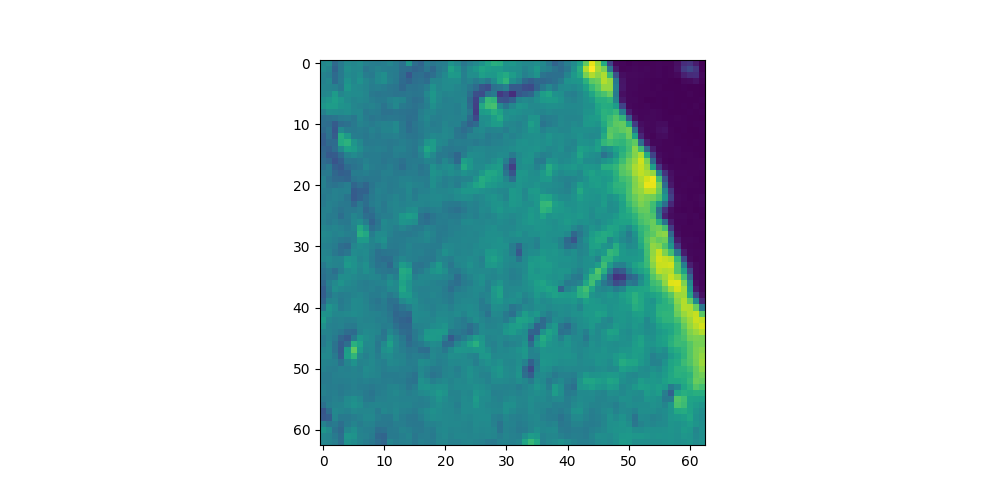

In [10]:
### Heatmap
%matplotlib widget
from scipy import signal
file = '2109_EC-roi1_masked.h5' #'2029_Dentate_gyrus-roi0_masked.h5'
window_size = 4
scattering = '_WAXS2'
directory = '/Volumes/HDD/BNL-Data/July-2021/sample-7/' # '/Users/bashit.a/Documents/Alzheimer/Dec-2020/'#'/Users/bashit.a/Documents/Alzheimer/July-2021/BNL-Data/sample-6/'
Iq = read_Iq(file, scattering, directory=directory)      # Iq shape (3721, 690)
Iq = Iq[:,310:334]
Width, Height = width_height(file ,directory=directory)
window  = np.ones(window_size)/window_size

Iq_f = np.zeros_like(Iq);
for frame in range(len(Iq)):
    Iq_f[frame] = np.convolve(window, Iq[frame], 'same')                   # outputs same length output and will be used for area and plotting
Iq_new = Iq - Iq_f

diff_patterns = find_rep_value(qgrid2, Iq_f, method = 'circ')
img_orig = snaking(Width, Height, diff_patterns)

f, ax = plt.subplots(1, 1, num=f'{file} Heat maps', figsize=(10,5))
# plot_heat_map_from_data(img_orig, Width, Height, args=(f,ax), title= None, cmap=discrete_cmap(N=10, base_cmap = 'cubehelix'))
plt.imshow(img_orig)

TypeError: 'NoneType' object is not subscriptable

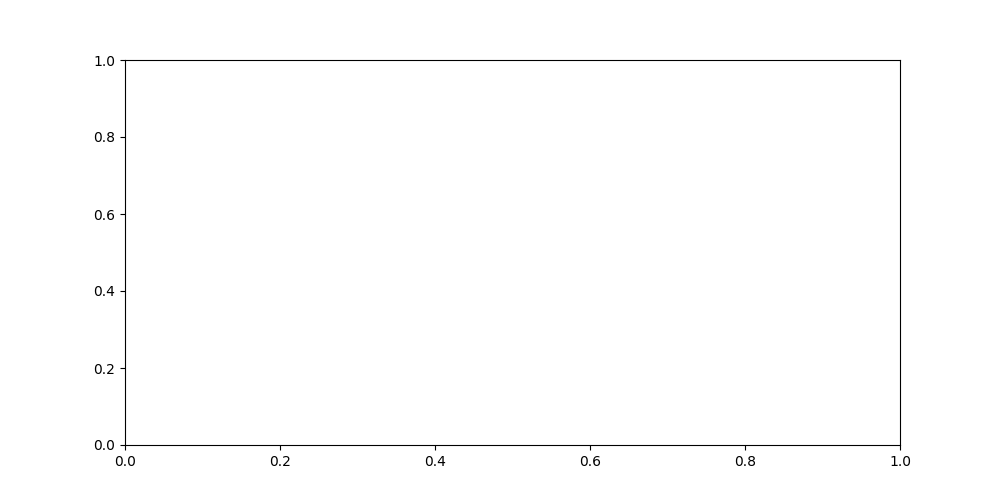

In [24]:
%matplotlib widget
f, axs = plt.subplots(1, 1, num=f'{file} Heat maps', figsize=(10,5))

plot_heat_map_from_file(file, qgrid2, scatterings = None, heatmap_rep_value = 'circ', cmap = 'viridis', args = (f,axs), bins=None)

In [21]:
file, cwd

('2109_EC-roi1_masked.h5', '/Volumes/HDD/BNL-Data/July-2021/sample-7')